## Installation

In [18]:
%pip install fastai==2.7.10
%pip install timm==0.6.12

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Training

In [1]:
from fastai.vision.all import *

/home/dnth/anaconda3/envs/timm-edge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trn_path = Path('../data/train_images')

In [9]:
dls = ImageDataLoaders.from_folder(trn_path, seed=316, valid_pct=0.2, bs=128,
                                item_tfms=[Resize((224, 224))], 
                                batch_tfms=aug_transforms(min_scale=0.75))


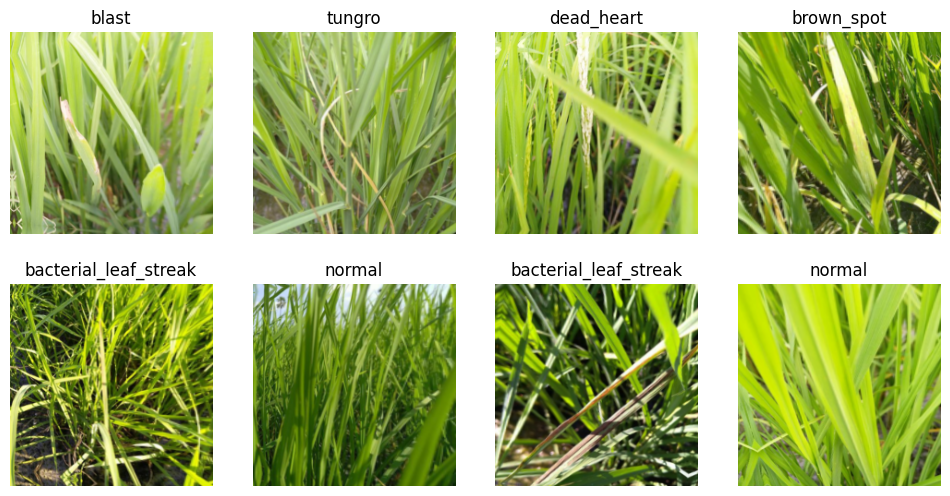

In [10]:
dls.train.show_batch(max_n=8, nrows=2)

In [11]:
# All models on timm
import timm
len(timm.list_models('*'))

964

In [12]:
timm.list_models('*edge*')

['cs3edgenet_x',
 'cs3se_edgenet_x',
 'edgenext_base',
 'edgenext_small',
 'edgenext_small_rw',
 'edgenext_x_small',
 'edgenext_xx_small']

In [13]:
learn = vision_learner(dls, 'edgenext_xx_small', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

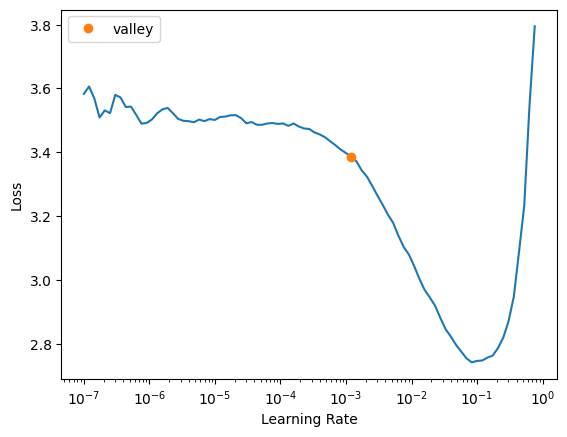

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.891988,1.189868,0.625180,00:26


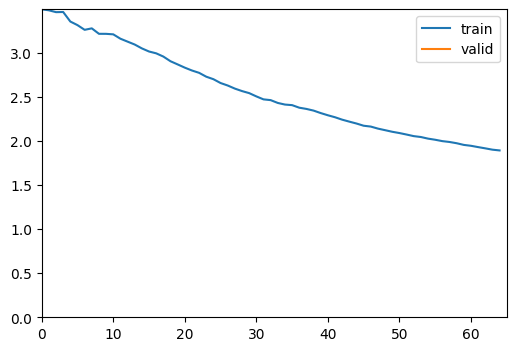

epoch,train_loss,valid_loss,accuracy,time
0,1.180979,0.817668,0.720807,00:27
1,1.026986,0.662517,0.772705,00:26
2,0.846028,0.590595,0.801538,00:26
3,0.720100,0.532896,0.834695,00:26
4,0.638478,0.504240,0.840461,00:25


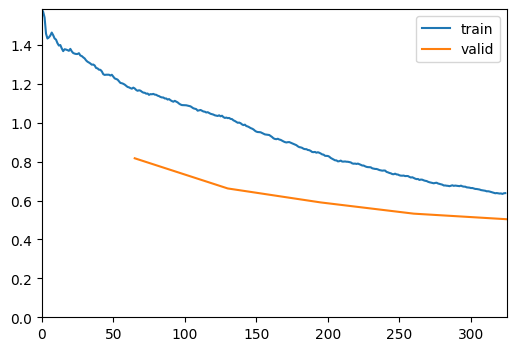

In [15]:
learn.fine_tune(5, base_lr=1e-2, cbs=[ShowGraphCallback()])

In [16]:
learn.export("../../train/export.pkl")

## Export to TorchScript

In [17]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

learn.model.cpu()
learn.model.eval();
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(learn.model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model.pt")